## Name : Asmaul Hossain Akash
## ID: 20-44209-3
### Assignment 1 on Image Classification on CIFAR-10 dataset
- Dataset consists of 60,000 32x32 color images, ie 6000 images per class. 
- We need to design a model to predict the label of these images correctly. 
- Data Source: https://github.com/YoongiKim/CIFAR-10-images

In [1]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import platform

### Loading Training Dataset

In [2]:
TRAIN_DIR = './data/train'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 5000/5000 [00:17<00:00, 277.79it/s]

50000


#### Visualizing the Dataset

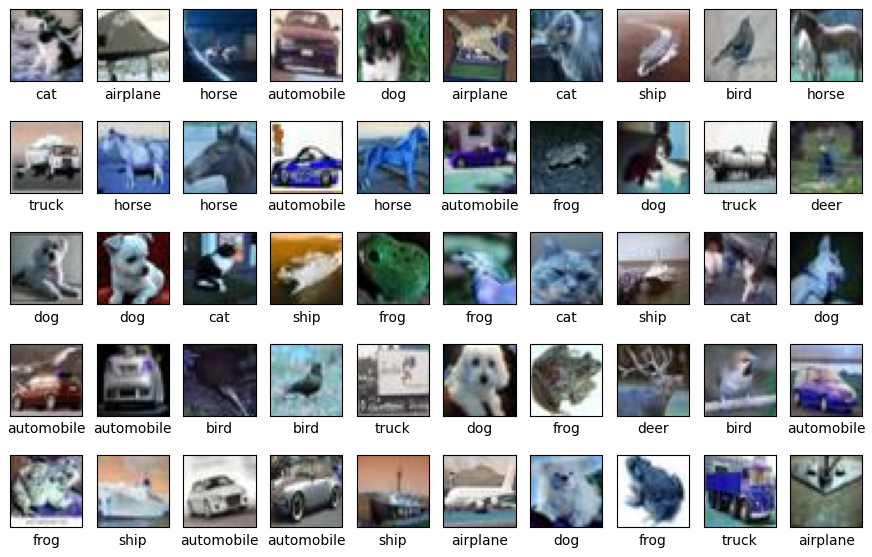

In [4]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(11,7))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(TRAIN_DATA[i][0])
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

In [5]:
f0 = TRAIN_DATA[0:1000]
f1 = TRAIN_DATA[1000:2000]
f2 = TRAIN_DATA[2000:3000]
f3 = TRAIN_DATA[3000:4000]
f4 = TRAIN_DATA[4000:5000]

### Calculating Distance

In [7]:
k_max = 10

def l1_dist(x, y):
    return np.sum(np.abs(x - y))

def l2_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def knn(train, validation, k):
    preds = []
    for v in validation:
        distances = []
        for t in train:
            l2 = l2_dist(v[0], t[0])
            distances.append((l2, t[1]))
        distances.sort(key=lambda x: x[0])
        neighbors = [d[1] for d in distances[:k]]
        counts = np.bincount(neighbors)
        pred = np.argmax(counts)
        preds.append(pred)
    return preds

mean_accuracies_l1 = []
std_accuracies_l1 = []
mean_accuracies_l2 = []
std_accuracies_l2 = []

for k in tqdm(range(1, k_max+1)):
    fold_accuracies_l1 = []
    fold_accuracies_l2 = []
    
    for i in range(5):
        if i == 0:
            train = f1+f2+f3+f4
            validation = f0
        elif i == 1:
            train = f0+f2+f3+f4
            validation = f1
        elif i == 2:
            train = f1+f0+f3+f4
            validation = f2
        elif i == 3:
            train = f1+f2+f0+f4
            validation = f3
        elif i == 4:
            train = f1+f2+f3+f0
            validation = f4

        acc_l1 = 0
        acc_l2 = 0

        for v in validation:
            l1_dists = []
            l2_dists = []
            for t in train:
                l1 = l1_dist(v[0], t[0])
                l2 = l2_dist(v[0], t[0])
                l1_dists.append((l1, t[1]))
                l2_dists.append((l2, t[1]))
            l1_dists.sort(key=lambda x: x[0])
            l2_dists.sort(key=lambda x: x[0])

            neighbors_l1 = [d[1] for d in l1_dists[:k]]
            counts_l1 = np.bincount(neighbors_l1)
            pred_l1 = np.argmax(counts_l1)

            neighbors_l2 = [d[1] for d in l2_dists[:k]]
            counts_l2 = np.bincount(neighbors_l2)
            pred_l2 = np.argmax(counts_l2)

            if pred_l1 == v[1]:
                acc_l1 += 1
            if pred_l2 == v[1]:
                acc_l2 += 1

        fold_accuracies_l1.append(acc_l1 / len(validation))
        fold_accuracies_l2.append(acc_l2 / len(validation))

    mean_accuracies_l1.append(np.mean(fold_accuracies_l1))
    std_accuracies_l1.append(np.std(fold_accuracies_l1))
    mean_accuracies_l2.append(np.mean(fold_accuracies_l2))
    std_accuracies_l2.append(np.std(fold_accuracies_l2))

100%|██████████| 10/10 [1:31:33<00:00, 549.34s/it]


### Plotting the L1 and L2 Distance

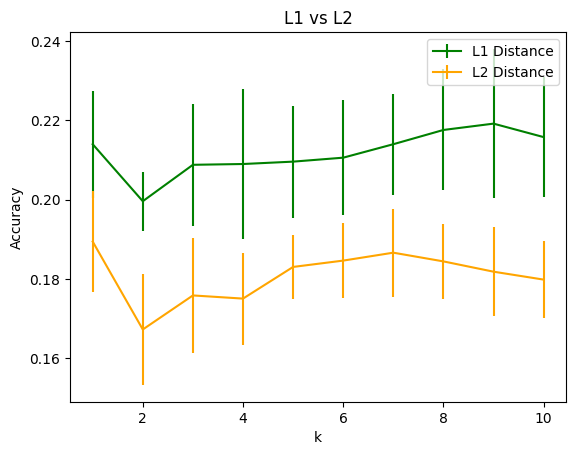

In [9]:
plt.errorbar(range(1, k_max+1), mean_accuracies_l1, yerr=std_accuracies_l1, label="L1 Distance",color="green")
plt.errorbar(range(1, k_max+1), mean_accuracies_l2, yerr=std_accuracies_l2, label="L2 Distance",color="orange")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("L1 vs L2")
plt.legend()
plt.show()

#### Now let's work on CIFAR-10  Batch Dataset using KNearestNeighbor Class

In [80]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred

### Utilizing Dataset

In [81]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Data subsampling

In [82]:
num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

# Memory error prevention by subsampling data

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# reshaping data and placing into rows

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(10000, 3072) (1000, 3072)


### Performing K-Nearest-Neighbor [KNN]

k = 1, Got 283 / 1000 correct => accuracy: 0.283000
k = 2, Got 252 / 1000 correct => accuracy: 0.252000
k = 3, Got 280 / 1000 correct => accuracy: 0.280000
k = 4, Got 286 / 1000 correct => accuracy: 0.286000
k = 5, Got 296 / 1000 correct => accuracy: 0.296000
k = 6, Got 287 / 1000 correct => accuracy: 0.287000
k = 7, Got 285 / 1000 correct => accuracy: 0.285000
k = 8, Got 276 / 1000 correct => accuracy: 0.276000
k = 9, Got 283 / 1000 correct => accuracy: 0.283000
k = 10, Got 288 / 1000 correct => accuracy: 0.288000
k = 11, Got 290 / 1000 correct => accuracy: 0.290000
k = 12, Got 285 / 1000 correct => accuracy: 0.285000
k = 13, Got 287 / 1000 correct => accuracy: 0.287000
k = 14, Got 294 / 1000 correct => accuracy: 0.294000


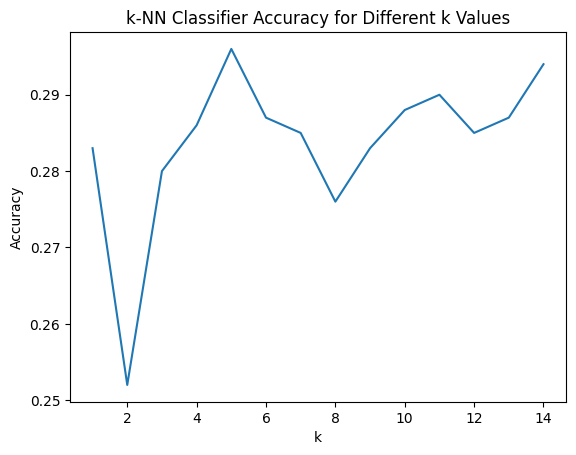

In [83]:
accuracies = []
for k in range(1, 15):
    classifier = KNearestNeighbor()
    classifier.train(X_train, y_train)
    dists = classifier.compute_distances(X_test)
    y_test_pred = classifier.predict_labels(dists, k=k)
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    accuracies.append(accuracy)
    print('k = %d, Got %d / %d correct => accuracy: %f' % (k, num_correct, num_test, accuracy))
    
plt.plot(range(1, 15), accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k-NN Classifier Accuracy for Different k Values')
plt.show()


### We got accuracy around 30% for different k values
Now let's take another approach model to get optimum accuracy

### Cross Validation

In [84]:
# Performing 5-fold cross validation on k-NN for varying values of k
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)


print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.577000
k = 1, accuracy = 0.568000
k = 1, accuracy = 0.565000
k = 1, accuracy = 0.549000
k = 1, accuracy = 0.554000
k = 3, accuracy = 0.575000
k = 3, accuracy = 0.548000
k = 3, accuracy = 0.557000
k = 3, accuracy = 0.535000
k = 3, accuracy = 0.531000
k = 5, accuracy = 0.589000
k = 5, accuracy = 0.568000
k = 5, accuracy = 0.595000
k = 5, accuracy = 0.550000
k = 5, accuracy = 0.557000
k = 8, accuracy = 0.597000
k = 8, accuracy = 0.592000
k = 8, accuracy = 0.568000
k = 8, accuracy = 0.548000
k = 8, accuracy = 0.572000
k = 10, accuracy = 0.605000
k = 10, accuracy = 0.574000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.532000
k = 10, accuracy = 0.570000
k = 12, accuracy = 0.609000
k = 12, accuracy = 0.587000
k = 12, accuracy = 0.571000
k = 12, accuracy = 0.530000
k = 12, accuracy = 0.551000
k = 15, accuracy = 0.588000
k = 15, accuracy = 0.594000
k = 15, accuracy = 0.550000
k = 15, accuracy = 0.548000
k = 15, acc

### Model Evaluation

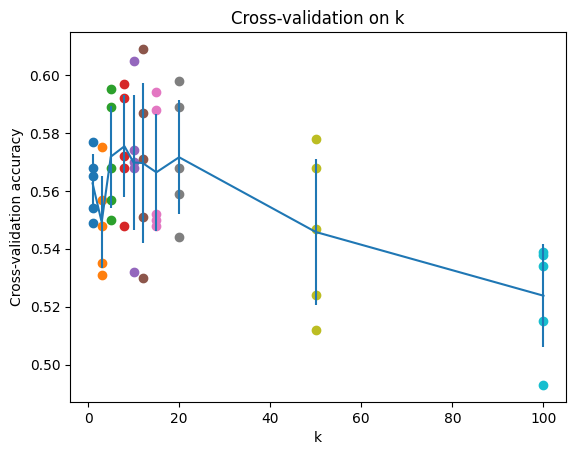

In [85]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()


In [86]:
# Choosing best value of k based on cross-validation results

best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Computing and displaying the accuracy for best k found during cross-validation
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 570 / 1000 correct => accuracy: 0.570000


### We got the best accuracy around 57% on cross validation

##### Why less accuracy?

We might be wondering why we can't get an accuracy any higher. First things first, 50% isn't bad for a simple KNN. Pure guessing would get 10% accuracy. That's because there are many more techniques that can be applied to this model.

The code is implementing the k-Nearest Neighbor algorithm for the CIFAR-10 dataset.

It first loads the dataset using the load_CIFAR10 function which returns the training set (X_train and y_train) and the test set (X_test and y_test).

It then subsamples the training and test set to reduce memory usage.

The KNearestNeighbor class is defined which has two methods: train and predict. The train method saves the training data (X_train and y_train) to the object's variables. The predict method first computes the distances between the test data and the training data using the compute_distances method. The predict_labels method then takes these distances and outputs the predicted labels for the test data.

The compute_distances method uses a numpy broadcasting trick to compute the pairwise distances between the test and training data.

The predict_labels method then takes the top k nearest training labels and uses numpy's bincount function to get the label with the most votes. This label is returned as the predicted label for the corresponding test data.

Finally, the code tests the KNearestNeighbor class on the CIFAR-10 test set and reports the accuracy. It also performs cross-validation to find the best k-value for the algorithm.